# Learn by example RNN/LSTM/GRU time series


This notebook is modified from https://www.kaggle.com/code/charel/learn-by-example-rnn-lstm-gru-time-series

I know I cannot predict stock prices based on historic data, but still the Recurring Neural network examples (RNN or Long Short-Term Memory, LSTM or Gated Recurrent Unit, GRU, etc) to predict stock prices are appealing, who knows I might discover something:-)

Welcome to my second  notebook on Kaggle. I did record my notes so it might help others in their journey to understand Neural Networks by examples (in this case using Recurring Networks stock predictions.) After seeing many youtube video's and various courses on Neural Networks found the Kaggle Keras course and examples helping me a lot to move from powerpoint understanding to run my own Neural Networks using Keras. Many thanks to this community! The least I could do is to contribute back, hence this notebook.  



<a id='sec1'></a>
# Introduction

Please watch this video about RNN/LSTM/GRU time series prediction, it gives you a good overview, it inspired me to reproduce the steps taken in this notebook:  
https://www.youtube.com/watch?v=2np77NOdnwk  
The code base:  
https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction  
I would like to acknowledge this tutorial for providing ideas and code, learning by example:  
https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook  
If you are new to Neural Networks you might want to have a look at my first notebook:  
https://www.kaggle.com/charel/learn-neural-networks-by-example-mnist-digits  


In [3]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

print ('import completed')

import completed


In [4]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation).
# So by design these networks are deep/long to catch recurrent patterns.
Enrol_window = 100

print ('enrol window set to',Enrol_window )

enrol window set to 100


In [5]:
# Support functions
sc = MinMaxScaler(feature_range=(0,1))
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


<a id='sec2'></a>
# Sinus wave proof of concept
First let's run some tests on a plain sinus wave and see of the Neural Network can predict it right, kind of proof of concept

<Axes: >

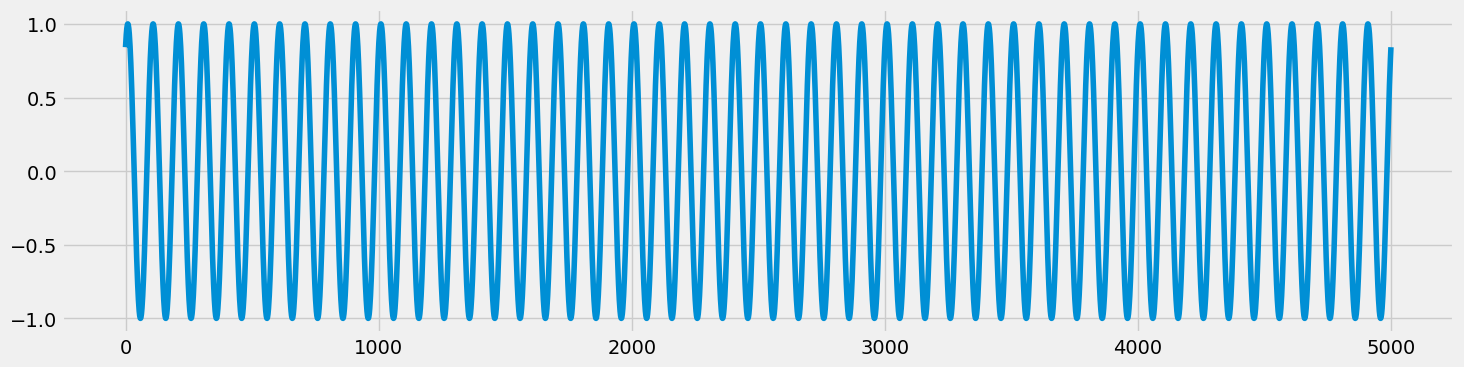

In [7]:
# from google.colab import files
# uploaded=files.upload()
# Load the data

dataset = pd.read_csv('Sin Wave Data Generator.csv')
dataset["Wave"][:].plot(figsize=(16,4),legend=False)

In [8]:
# Prepare the dataset, note that all data for the sinus wave is already normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case a stock price

feature_train, label_train, feature_test, label_test = load_data(dataset, 'Wave', Enrol_window, False)

print ('Datasets generated')
print(feature_train.shape,label_train.shape,dataset.shape)

Datasets generated
(4410, 100, 1) (4410,) (5001, 1)


In [9]:
# The LSTM model I would like to test
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

print (model.summary())


model compiled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 70901 (276.96 KB)
Trainable params: 70901 (276.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Non

In [10]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=10, validation_data = (feature_test, label_test))


Epoch 1/10
9/9 [==============================] - 18s 1s/step - loss: 0.3246 - val_loss: 0.1440
Epoch 2/10
9/9 [==============================] - 7s 764ms/step - loss: 0.0832 - val_loss: 0.0317
Epoch 3/10
9/9 [==============================] - 9s 980ms/step - loss: 0.0167 - val_loss: 0.0092
Epoch 4/10
9/9 [==============================] - 7s 772ms/step - loss: 0.0084 - val_loss: 0.0021
Epoch 5/10
9/9 [==============================] - 9s 972ms/step - loss: 0.0066 - val_loss: 0.0016
Epoch 6/10
9/9 [==============================] - 7s 773ms/step - loss: 0.0050 - val_loss: 4.9789e-04
Epoch 7/10
9/9 [==============================] - 9s 945ms/step - loss: 0.0047 - val_loss: 1.8530e-04
Epoch 8/10
9/9 [==============================] - 8s 844ms/step - loss: 0.0040 - val_loss: 3.9686e-04
Epoch 9/10
9/9 [==============================] - 8s 838ms/step - loss: 0.0038 - val_loss: 1.1124e-04
Epoch 10/10
9/9 [==============================] - 8s 945ms/step - loss: 0.0038 - val_loss: 9.5196e-05


1/1 [==============================] - 0s 35ms/step


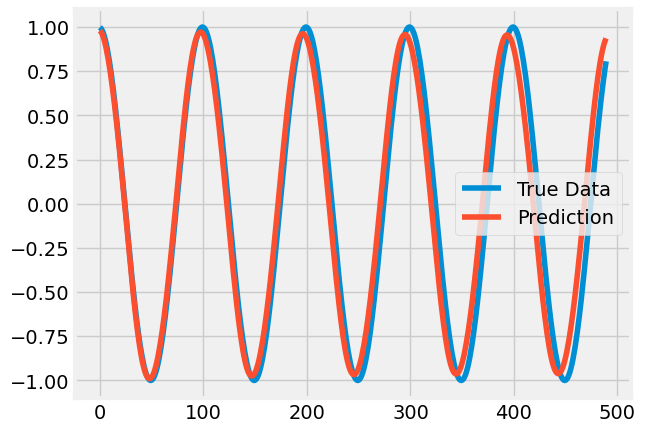

In [11]:
#Let's use the model and predict the wave
predictions= predict_sequence_full(model, feature_test, Enrol_window)
plot_results(predictions,label_test)


<a id='sec21'></a>
## Results
Actually not a bad result because remember the models predicts 500 steps in the future and more-over after the enrol_window length (eg 100 setps) the predictions are being made on predictions, so eny error quickly multiplies ba magnitudes.  
Having this confidence let's try to predicts some stock prices